In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import pandas as pd
#concatenando
df = pd.read_csv("C:\\Users\\lclai\\Desktop\\research LDIG\\data_dementia\\clean\\pitt_withoutwords.csv")
df = df[(df['label'] == 0) | (df['label'] == 1)]

df["sex"] = df["sex"].map({"M": 0, "F": 1})  
sex = df['sex'].to_numpy() 
age = df['age'].to_numpy().reshape(-1, 1)
# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df["clean_transcripts"]).toarray()

# Word2Vec
clean_text = df["clean_transcripts"].apply(lambda x: x.split())  
word2vec_model = Word2Vec(sentences=clean_text, vector_size=100, window=5, min_count=1, workers=4)

def get_word2vec_embedding(text, model):
    word_vectors = [model.wv[word] for word in text if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  
    return np.mean(word_vectors, axis=0)  

X_text_word2vec = np.array([get_word2vec_embedding(text, word2vec_model) for text in clean_text])


#X = np.hstack((X_numeric, X_tfidf, X_text_word2vec))

scaled = StandardScaler().fit_transform(np.hstack((age, X_text_word2vec)))

X = np.column_stack((sex, scaled))

y = LabelEncoder().fit_transform(df["label"])  

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [25]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtener las importancias de las características
importances = rf.feature_importances_

# Ordenar las características según su importancia
indices = np.argsort(importances)[::-1]

# Seleccionar las 50 características más importantes
X_train = X_train[:, indices[:50]]
X_test = X_test[:, indices[:50]]


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation AUC: 0.7525
AUC on test set: 0.8419
Accuracy on test set: 0.7900

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80        49
           1       0.84      0.73      0.78        51

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100



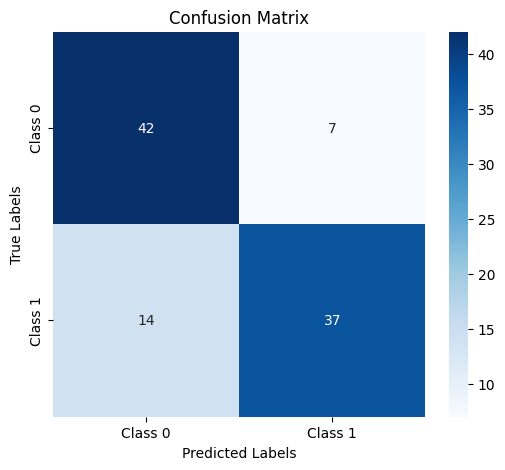

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_

y_pred = best_clf.predict(X_test)
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")
print(f"AUC on test set: {auc_score:.4f}")
print(f"Accuracy on test set: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 500],  
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt'],
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [100, 500],  
    'max_depth': [3, 6, 10],  
    'learning_rate': [0.01, 0.1, 0.3],  
    'subsample': [0.8, 1],
}

xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

rf_proba = rf_grid_search.best_estimator_.predict_proba(X_test)[:, 1]  
xgb_proba = xgb_grid_search.best_estimator_.predict_proba(X_test)[:, 1]  

ensemble_proba = (rf_proba + xgb_proba) / 2  

auc = roc_auc_score(y_test, ensemble_proba)
print(f"AUC (Ensemble RF + XGB): {auc}")

print("Best RF parameters: ", rf_grid_search.best_params_)
print("Best XGB parameters: ", xgb_grid_search.best_params_)


AUC (Ensemble RF + XGB): 0.8971588635454182
Best RF parameters:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best XGB parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1}
